# 3rd Model: SVM (Scalable Vector Machine) Model

The Scalable Vector Machine model can be used for both classification and regression tasks. It is particularly effective in high-dimensional spaces and is well-suited for cases where the data is not linearly separable. SVMs work by finding the optimal hyperplane that best separates different classes or predicts a continuous target variable. In a binary classification task, the SVM seeks to find the optimal hyperplane that maximally separates two classes. The hyperplane is a decision boundary in the feature space. For a two-dimensional space, the hyperplane is a line. In higher dimensions, it becomes a hyperplane. Support vectors are data points that are closest to the decision boundary (hyperplane). These points are critical in determining the position and orientation of the hyperplane. The margin is the distance between the hyperplane and the nearest data point from each class. SVM aims to maximize this margin, making the decision boundary robust to new data points.

For regression tasks, SVM aims to fit a hyperplane that captures the trend of the data while allowing a certain deviation. SVR introduces a tube around the regression line, and the goal is to fit the line within this tube, allowing for a certain deviation (controlled by the hyperparameter epsilon). SVR minimizes the loss function, which penalizes points that fall outside the tube.

Advantages:
- Effective in High Dimensions: SVM performs well even in high-dimensional spaces.
- Robust to Overfitting: By maximizing the margin, SVM tends to be less prone to overfitting.
- Versatile: Can handle both linear and non-linear relationships in data.

Limitations:
- Computational Complexity: Training an SVM can be computationally expensive, especially for large datasets.

#### Importing libraries and loading data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
df = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
df.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

#### Establishing input and output columns

In [9]:
x = df.drop('energy', axis=1)
y = df['energy']


#### Splitting data into training and testing sets

In [10]:
from sklearn.model_selection import train_test_split


In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=56)

#### Creating the pipeline

Previously I was using the ColumnTransformer to create a preprocessing pipeline to apply different scaling techniques to the columns. However,  I switched to using the Pipeline class to create a pipeline that applies the preprocessing steps and the model. This is because the ColumnTransformer does not allow for the use of the GridSearchCV, RandomSearchCV, or BayesSearchCV class to tune the hyperparameters of the model.

In [13]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# This is the preprocessing pipeline: SVMs need scaling and one-hot encoder
preprocessor = ColumnTransformer(
    transformers=[
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64)),
        ('OHE', OneHotEncoder(drop='first'), make_column_selector(dtype_include='category'))
    ],
    remainder='passthrough'
)
# We use gausian / radial kernel
svr = SVR(kernel="rbf")

# Combining the preprocessor with the SVM classifier in a pipeline
pipe_scale_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('SVM', svr)
])



# This is the preprocessing pipeline: SVMs need scaling
# pipe_scale_svr = Pipeline([
#     ('scale', scaler),
#     ('SVM', svr)])



# RandomizedSearchCV

Instead of trying out all possible combinations of hyperparameters, as GridSearchCV does, RandomizedSearchCV samples a fixed number of hyperparameter settings from specified probability distributions. This can be more efficient, especially when searching over a large hyperparameter space. 
- For cross validation, data will be split using K-Fold cross-validation with 3 folds.
- The budget sets the number of parameter settings to sample, which in this case is set to 20.

In [15]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import loguniform
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


param_grid_rand = {
    'SVM__C': loguniform(1e-1, 1e4),
    'SVM__gamma': loguniform(1e-4, 1e0),
}

inner = KFold(n_splits=3, shuffle=True, random_state=56)

budget = 20

hpo_pipe_scale_svr_rand = RandomizedSearchCV(pipe_scale_svr, param_grid_rand, n_iter=budget, cv=inner, scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, random_state=56)

hpo_pipe_scale_svr_rand.fit(X_train, y_train)

print(f"Best parameters set found on development set: {hpo_pipe_scale_svr_rand.best_params_}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters set found on development set: {'SVM__C': 8336.029689055413, 'SVM__gamma': 0.0021560015267633775}


In order to evaluate the model, I am checking the mean absolute error and the r squared score. The mean absolute error is the average of the absolute value of the errors between the predicted and actual values. The r squared score is the proportion of the variance in the dependent variable that is predictable from the independent variable. Because our date is bimodally skewed, I am using mean absolute error as the primary metric to evaluate the model.

In [20]:
y_pred_rand = hpo_pipe_scale_svr_rand.predict(X=X_test)
# jooa add get scores

Dont need the below cell anymore bc we have get scores

In [16]:
# Evaluate the model
mae_rand = mean_absolute_error(y_test, hpo_pipe_scale_svr_rand.predict(X=X_test))
print (f'Mean Squared Error: {mae_rand}')
r2_rand = r2_score(y_test, hpo_pipe_scale_svr_rand.predict(X=X_test))
print(f'R^2 Score: {r2_rand}')

Mean Squared Error: 5077727.921921764
R^2 Score: 0.3701547837790593


# Bayesian Optimization (BayesSearchCV)

Bayesian optimization builds a probabilistic model of the objective function (performance metric) and uses this model to decide the next set of hyperparameters to evaluate. It considers both the information gained from the model and the uncertainty associated with different hyperparameter settings. We chose his approach because it is more sample-efficient than grid and random search because it intelligently selects points in the hyperparameter space to sample, focusing on promising regions.

In [17]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real

# search space 
param_grid = {'SVM__C': Real(1e-1, 1e4, prior="log-uniform"),
              'SVM__gamma': Real(1e-3, 1e0, prior="log-uniform")}

inner = KFold(n_splits=3, shuffle=True, random_state=56)

budget = 20

hpo_pipe_scale_svr = BayesSearchCV(pipe_scale_svr, param_grid, n_iter=budget, cv=inner, scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, random_state=56)
hpo_pipe_scale_svr.fit(X_train, y_train)

print(f"Best parameters set found on development set: {hpo_pipe_scale_svr.best_params_}")



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters set found on development set: OrderedDict([('SVM__C', 4957.093753417356), ('SVM__gamma', 0.016675636965041696)])


In [ ]:
y_pred_bayes = hpo_pipe_scale_svr.predict(X=X_test)
# joao add the get scores

Dont need the below stuff anymore bc of get scores

In [18]:
# Evaluate the model
mae = mean_absolute_error(y_test, hpo_pipe_scale_svr.predict(X=X_test))
print (f'Mean Squared Error: {mae}')
r2 = r2_score(y_test, hpo_pipe_scale_svr.predict(X=X_test))
print(f'R^2 Score: {r2}')

Mean Squared Error: 6252765.847308698
R^2 Score: 0.09977780198818287


## Data Visualization

The following convergence plot will show us if the optimization has converged. A convergence plot provides insights into how well the optimization algorithm is progressing over iterations. Steep drop-offs indicate key points where the algorithm made significant improvements, and the negative correlation shows that, on average, the algorithm is moving toward better hyperparameter configurations. Monitoring convergence is essential to assess the effectiveness of the optimization process and determine when to stop further exploration. Here we see steep drop offs at number of calls n=5 and n=11. 

X-Axis (n): The number of calls or iterations of the optimization algorithm. Each call represents a trial where a set of hyperparameters is evaluated.

Y-Axis (minf(x)): The value of the objective function (minf) after n calls. The objective function is the function that the optimization algorithm is trying to minimize or maximize.

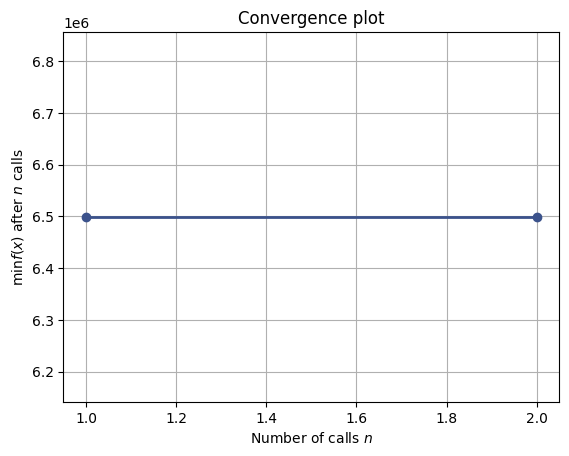

In [19]:
from skopt.plots import plot_convergence

_ = plot_convergence(hpo_pipe_scale_svr.optimizer_results_[0])
plt.show()

### Summary of Results

From the results we can see the r2 value of _________ and the mean absolute error of _________. The SVM model was the model that performed the worst out of the 5 different models. This may be due to the complexity of the data. SVMs might not perform well on highly complex datasets or datasets with intricate patterns. They work well when there is a clear margin of separation between classes. If the relationship between features and the target variable is not well-captured by hyperplanes, SVMs may struggle. SVM's are also computationally complex, so with the limited capabilities of my computer I had to have a low budget of 20. With a more capable computer, I would have been able to make a higher budget, and therefore get more accurate results. 